In [107]:
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import json
from bs4 import BeautifulSoup
from string import punctuation
import csv
import random

# Data Import and basic cleaning
We will start by importing the data from a file consisting of many JSON objects, one per line. There was some unexpected encoding issues when using the Pandas read_json function, so we will do it the old fashioned way and read the raw text into memory, then enumerate through the loop and only keep the objects that can be successfully serialized into a dictionary object. Once that is complete we will create a Pandas DataFrame of the result and save it to a pickle file for easy reading at a later date.

In [2]:
with open('top_10_channels.json','r') as file:
    raw_data = file.read().split("\n")

In [3]:
full_json = []
for i,x in enumerate(raw_data):
    try:
        full_json.append(json.loads(x))
    except :
        print(i)
        

521067
632258
731392
893765
1024032
1055899
1158113
1215489
1286623


In [4]:
raw_data[632258].encode().decode(encoding='unicode-escape')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: invalid escape sequence '\/'
  """Entry point for launching an IPython kernel.


'{"channel":"ru","Id":"876325","question":"<p>Мне нужно получить все картинки из папки (storage\\/app\\/images) в контроллере, выбрать из них только нужные, создав из них массив. Передать этот массив на страницу и вывести в цикле с помощью Blade в src.\nСкажите пожалуйста, как это можно сделать?<\\/p>\n","answer":"<p>Прежде всего нужно включить доступ к storage, подробнее <a href="https:\\/\\/stackoverflow.com\\/questions\\/30191330\\/laravel-5-how-to-access-image-uploaded-in-storage-within-view">здесь<\\/a>.\nДальше нужно перебрать все файлы и добавить каждый в массив.<\\/p>\n\n<pre><code>$imagesPath = storage_path(\'app\\/images\\/\'); \\/\\/ путь к папке с картинками\n$files = []; \\/\\/ массив файлов\n\nforeach (glob($imagesPath . "*.{jpg,png,gif}", GLOB_BRACE) as $filename) { \\/\\/ ищет все картинки через glob\n    $files[] = $filename;\n}  \n\nreturn view(\'welcome\', compact(\'files\'));\n<\\/code><\\/pre>\n\n<p>Теперь в blade можно вывести вот так:<\\/p>\n\n<pre><code>@foreach

This example was interesting, the Python JSON serializer could not handle encoding Russian text into a JSON object, and thus it fails.

In [5]:
full_df = pd.DataFrame(full_json)

In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339625 entries, 0 to 1339624
Data columns (total 4 columns):
Id          1339625 non-null object
answer      1339625 non-null object
channel     1339625 non-null object
question    1339625 non-null object
dtypes: object(4)
memory usage: 40.9+ MB


## Sampling the dataset
Due to the nature of NLTK classifiers looking for a list of dictionaries for a featureset, we must sample this data. The original 1.6 million questions (from 20 channels) quickly exhausted 128 GB of RAM. The same behavior occurred when we reduced the number of records to 1.3 million (10 channels).<br>
Unique words in feature set was also reduced, from the original 5k to a modest 2k and there was still not enough memory. This is due to the ineffecient data structure of a list of dictionaries because each item in the list needed to store strings for 2k or 5k words, plus a boolean value. The strings as keys leads to large memory consumption alone, at 5k features this would amount to almost 8 billion keys in the list. Using the minimum size of a string in Python (40 bytes) that is almost 320 GB of RAM needed to store the keys alone.<br>
For this reason, we will check the original distribution of channels, then sample the data to 20% of the original size, and check the distribution once again to ensure we maintained a representive sample of the channels.

In [7]:
full_df['channel'].value_counts()/full_df['channel'].count()

math           0.388965
superuser      0.121207
serverfault    0.097241
ru             0.083001
askubuntu      0.076300
tex            0.074001
unix           0.053099
pt             0.042829
physics        0.039571
codereview     0.023787
Name: channel, dtype: float64

In [21]:
sampled_df = full_df.sample(frac=.2,replace=False,random_state=88)
sampled_df.reset_index(inplace=True)

In [22]:
sampled_df['channel'].value_counts()/sampled_df['channel'].count()

math           0.388071
superuser      0.120347
serverfault    0.096486
ru             0.084180
askubuntu      0.076611
tex            0.074775
unix           0.053422
pt             0.042691
physics        0.039448
codereview     0.023969
Name: channel, dtype: float64

In [10]:
sampled_df.drop(columns=['answer'],inplace=True)

The sampling was able to keep the original distribution with almost perfect accuracy.

In [23]:
sampled_df.to_pickle('top_10_channels_sampled.pickle')

# Tokenization and vectorization

## Use beautiful soup to parse the html out of the text

In [12]:
def parse_html(text):
    parsed_text = BeautifulSoup(text).get_text()
    return parsed_text

Example of unparsed text

In [24]:
sampled_df.iloc[2]['question']

'<p>Let $D$ be an open disc centred at the origin in $\\mathbb{R}^2$. Give $D$ a Riemannian metric of the the form $(dx^2+dy^2)/f(r)^2$, where $r=\\sqrt{x^2+y^2}$ and $f(r)&gt;0$. Show that the curvature of this metric is $K = ff\'\' - (f\')^2 + ff\'/r$. </p>\n\n<p>First of all, I am confused as to what the question means by "curvature of the metric". I have previously only studies how to calculate the Gauss curvature of embedded surfaces, and am not sure how to proceed in this case. Many thanks for you help.</p>\n'

Parse and view to show html removed

In [25]:
parse_html(sampled_df.iloc[2]['question'])

'Let $D$ be an open disc centred at the origin in $\\mathbb{R}^2$. Give $D$ a Riemannian metric of the the form $(dx^2+dy^2)/f(r)^2$, where $r=\\sqrt{x^2+y^2}$ and $f(r)>0$. Show that the curvature of this metric is $K = ff\'\' - (f\')^2 + ff\'/r$. \nFirst of all, I am confused as to what the question means by "curvature of the metric". I have previously only studies how to calculate the Gauss curvature of embedded surfaces, and am not sure how to proceed in this case. Many thanks for you help.\n'

Call this function on all text in the questions column of the dataframe

In [26]:
sampled_df['question'] = sampled_df['question'].apply(parse_html)

The results of the parser look to have done a good job. Let's save the results again in the pickle because the parsing took a really long time.

In [27]:
sampled_df.to_pickle('top_10_channels_sampled.pickle')

In [28]:
def tokenize_questions(question):
    sent = nltk.word_tokenize(question)
    sent = [word.lower() for word in sent]
    sent = [word for word in sent if word not in punctuation]
    #sent = [word for word in sent if len(word) > 3]
    return(sent)

In [29]:
sampled_df.loc[1:10]['question'].apply(tokenize_questions)

1     [como, remover, esses, arquivos, do, meu, ramo...
2     [let, d, be, an, open, disc, centred, at, the,...
3     [i, have, the, netgear, router, which, has, bu...
4     [i, hope, i, 've, posted, this, in, the, prope...
5     [a, cartier, divisor, on, a, scheme, x, is, ef...
6     [my, employer, just, bought, a, building, with...
7     [i, am, currently, running, windows, server, 2...
8     [i, would, like, to, have, separate, browser, ...
9     [всем, привет, есть, список, ul, li, ..., /li,...
10    [how, can, i, find, only, the, catalogs, and, ...
Name: question, dtype: object

In order to construct our word distribution we must collect all tokenized words in a list

In [30]:
all_words = [word for sent in sampled_df['question'].apply(tokenize_questions) for word in sent]

In [31]:
len(all_words)

37186506

This shows that there are 37 million words in the sampled corpus. To make use of the words we construct a word frequency distribution to pull out the most common words.

In [32]:
all_words_freq = nltk.FreqDist(all_words)

In [33]:
len(all_words_freq)

1390900

This results in an astonishing 1.4 million unique features. This data should really be further processed to reduce the number of features to just those that provide valid signal to the classifier, however, the instructions for the assignment state to use as little filtering as possible. We will have a look at the 50 most common words and see how leaving stop words will affect our outcome.

In [35]:
all_words_freq.most_common(50)

[('the', 1226697),
 ('i', 943617),
 ('to', 732508),
 ('a', 690848),
 ('is', 576152),
 ("''", 555984),
 ('and', 473818),
 ('of', 460125),
 ('that', 352445),
 ('in', 346246),
 ('it', 304846),
 ('this', 281528),
 ('``', 277574),
 ('for', 269585),
 ('1', 228349),
 ('--', 209936),
 ('x', 209522),
 ('if', 199494),
 ('0', 197820),
 ('on', 182234),
 ('have', 181975),
 ('be', 179861),
 ('with', 174947),
 ('but', 172062),
 ('not', 171870),
 ('my', 157804),
 ('can', 151712),
 ('do', 137686),
 ('as', 137319),
 ('2', 133704),
 ('are', 119145),
 ("n't", 113234),
 ('from', 112543),
 ('how', 112532),
 ('so', 111666),
 ('n', 106291),
 ('or', 104916),
 ('there', 103832),
 ('an', 103427),
 ('f', 101630),
 ('what', 91221),
 ('we', 89126),
 ('at', 87879),
 ('by', 86749),
 ('\\frac', 85985),
 ("'s", 85835),
 ('then', 82335),
 ('...', 81238),
 ('any', 81032),
 ("'m", 79280)]

In [36]:
all_words_freq.most_common(2000)[-100:]

[('35', 1901),
 ('modify', 1900),
 ('0.0.0.0', 1900),
 ('dec', 1899),
 ('28', 1895),
 ('função', 1895),
 ('removing', 1894),
 ('\\mathscr', 1891),
 ('logged', 1890),
 ('convergent', 1888),
 ('prefer', 1887),
 ('units', 1885),
 ('offset', 1884),
 ('satisfy', 1884),
 ('resolution', 1882),
 ('x\\to', 1881),
 ('arr', 1880),
 ('measurable', 1880),
 ('apparently', 1878),
 ('endl', 1877),
 ('convex', 1877),
 ('fast', 1875),
 ('bug', 1874),
 ('eigenvalues', 1874),
 ('ошибка', 1866),
 ('rx', 1863),
 ('isomorphism', 1862),
 ('массив', 1861),
 ('toc', 1861),
 ('x-1', 1860),
 ('multiplication', 1860),
 ('stored', 1858),
 ('logical', 1858),
 ('cells', 1858),
 ('upon', 1853),
 ('increase', 1853),
 ('typename', 1852),
 ('incorrect', 1851),
 ('welcome', 1849),
 ('aware', 1849),
 ('assim', 1846),
 ('=\\sum_', 1843),
 ('indeed', 1842),
 ('neither', 1842),
 ('pick', 1840),
 ('quantum', 1839),
 ('jquery', 1837),
 ('fit', 1835),
 ('почему', 1835),
 ('past', 1834),
 ('faster', 1832),
 ('man', 1831),
 ('2010

The last 100 words of the top 2000 features show a steep drop off in word frequency, with only 1.7k appearances. This seems like a reasonable number of features to classify.

To clean up some memory usage we will drop the all_words list now and save the top 2000 features of the FreqDist to a file for checkpointing.

In [37]:
del(all_words)
with open('freq_dist.csv','w',newline='',encoding='utf-8') as fd_out:
    writer = csv.writer(fd_out)
    for key,count in all_words_freq.most_common(2000):
        writer.writerow([key,count])

In [38]:
word_features = [word for (word,count) in all_words_freq.most_common(2000)]

### Define the function to create a featureset

In [39]:
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

Test the new function out on the first document

In [40]:
test_features = document_features(sampled_df.iloc[0]['question'],word_features)
for feature in list(test_features.keys())[:10]:
    print(feature,test_features[feature])

V_the False
V_i True
V_to False
V_a True
V_is False
V_'' False
V_and False
V_of False
V_that False
V_in False


### Construct the Feature Set

The first step in creating a feature set is to tokenize the words in the Pandas Series into a list and combine them with the channel label. To do this we will create a function that returns the tokenized document and the channel as a list object

In [41]:
def munge_df(row):
    return([tokenize_questions(row['question']),row['channel']])

In [47]:
doc_feat_list = sampled_df.apply(func= munge_df, axis=1)

Check the first row of doc_feat_list to ensure it worked

In [48]:
doc_feat_list[0]

[['seeking',
  'to',
  'improve',
  'upon',
  'my',
  'high',
  'score',
  "'module",
  'code',
  'it',
  'saves',
  'users',
  'high',
  'score',
  'in',
  'a',
  'pickle',
  'database',
  'and',
  'if',
  'needed',
  'prints',
  'out',
  'the',
  'current',
  'scores',
  'in',
  'the',
  'database',
  'import',
  'pickle',
  'import',
  'os',
  'global',
  'high_scores',
  'def',
  'setup_scores',
  'global',
  'high_scores',
  'high_scores',
  'if',
  'os.path.isfile',
  "'highscores.pkl",
  'with',
  'open',
  '``',
  'highscores.pkl',
  "''",
  '``',
  'rb',
  "''",
  'as',
  'h',
  'high_scores',
  'pickle.load',
  'h',
  'else',
  'high_scores',
  '``',
  'adam',
  'smith',
  "''",
  '65536',
  '``',
  'john',
  'doe',
  "''",
  '10000',
  'def',
  'save_score',
  'name',
  'score',
  'new_score',
  'name',
  'score',
  'if',
  'new_score',
  '0',
  'in',
  'high_scores',
  'if',
  'new_score',
  '1',
  'high_scores',
  'new_score',
  '0',
  'high_scores',
  'new_score',
  '0',


Let's suffle the list so we don't miss some channels in training due to the train/test split.

In [49]:
random.shuffle(doc_feat_list)
random.shuffle(doc_feat_list)

In [50]:
featuresets = [(document_features(d, word_features), c) for (d, c) in doc_feat_list]

In [58]:
split = int(np.floor(len(featuresets)*.8))
train_set = featuresets[:split]
test_set = featuresets[split:]

In [59]:
len(train_set)

214340

In [60]:
len(test_set)

53585

In [61]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [62]:
nltk.classify.accuracy(classifier, test_set)

0.7966035271064663

In [70]:
predicted_labels = classifier.classify_many([x for (x,l) in test_set])
true_labels = [c for (x,c) in test_set]
cm = confusion_matrix(y_pred=predicted_labels,y_true=true_labels)

In [71]:
print(cm)

[[ 2397    23    35     1     0    53   267   990     5   435]
 [    1  1160    26     0     4    16    10    33     5    71]
 [    3   170 18915  1352     0    51    10    90    40    12]
 [    0    13   411  1670     0    12     5    37     2     0]
 [    1     7     1     0  2280     4     0     0     0     0]
 [    0    11     0     0     1  4497     0     1     1     9]
 [  310    49    30    15     0    28  3006  1227     3   509]
 [  581    99    71    30     0    49   799  4019    49   653]
 [   57    30   204    23     1    15     5   233  3400    68]
 [  388    66    30     5     0    22   391   627    13  1342]]


In [74]:
np.unique(true_labels)

array(['askubuntu', 'codereview', 'math', 'physics', 'pt', 'ru',
       'serverfault', 'superuser', 'tex', 'unix'], dtype='<U11')

In [75]:
cm = confusion_matrix(y_pred=predicted_labels,y_true=true_labels,labels=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix'])

In [76]:
print(cm)

[[ 2397    23    35     1     0    53   267   990     5   435]
 [    1  1160    26     0     4    16    10    33     5    71]
 [    3   170 18915  1352     0    51    10    90    40    12]
 [    0    13   411  1670     0    12     5    37     2     0]
 [    1     7     1     0  2280     4     0     0     0     0]
 [    0    11     0     0     1  4497     0     1     1     9]
 [  310    49    30    15     0    28  3006  1227     3   509]
 [  581    99    71    30     0    49   799  4019    49   653]
 [   57    30   204    23     1    15     5   233  3400    68]
 [  388    66    30     5     0    22   391   627    13  1342]]


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 2397    23    35     1     0    53   267   990     5   435]
 [    1  1160    26     0     4    16    10    33     5    71]
 [    3   170 18915  1352     0    51    10    90    40    12]
 [    0    13   411  1670     0    12     5    37     2     0]
 [    1     7     1     0  2280     4     0     0     0     0]
 [    0    11     0     0     1  4497     0     1     1     9]
 [  310    49    30    15     0    28  3006  1227     3   509]
 [  581    99    71    30     0    49   799  4019    49   653]
 [   57    30   204    23     1    15     5   233  3400    68]
 [  388    66    30     5     0    22   391   627    13  1342]]


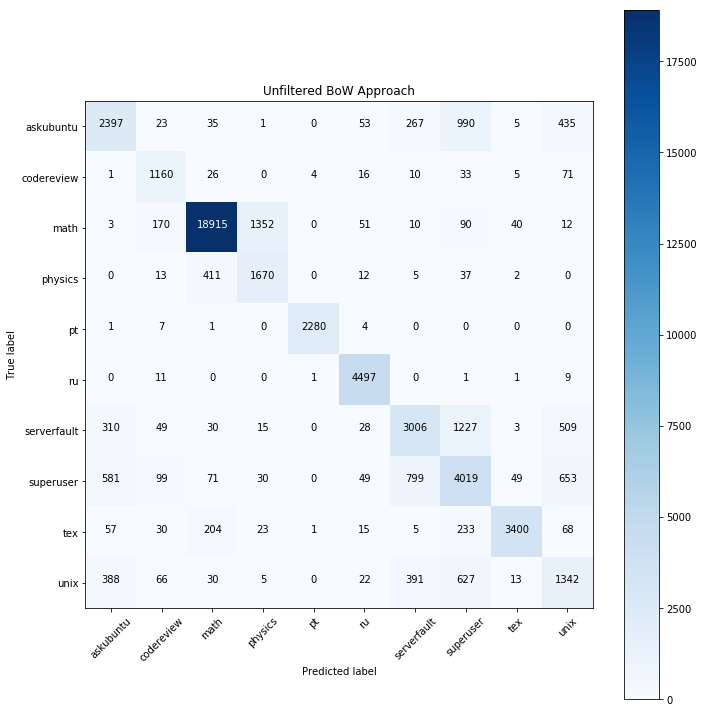

In [172]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,normalize=False,classes=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix'],title="Unfiltered BoW Approach")
plt.savefig('raw_BoW_cm.jpg')

In [78]:
print('Unfiltered BoW Classification Report\n')
print(classification_report(true_labels,predicted_labels,target_names=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix']))

Unfiltered BoW Classification Report

              precision    recall  f1-score   support

   askubuntu       0.64      0.57      0.60      4206
  codereview       0.71      0.87      0.79      1326
        math       0.96      0.92      0.94     20643
     physics       0.54      0.78      0.64      2150
          pt       1.00      0.99      1.00      2293
          ru       0.95      0.99      0.97      4520
 serverfault       0.67      0.58      0.62      5177
   superuser       0.55      0.63      0.59      6350
         tex       0.97      0.84      0.90      4036
        unix       0.43      0.47      0.45      2884

   micro avg       0.80      0.80      0.80     53585
   macro avg       0.74      0.76      0.75     53585
weighted avg       0.81      0.80      0.80     53585



In [79]:
classifier.most_informative_features()

[('V_uma', True),
 ('V_\\usepackage', True),
 ('V_ubuntu', True),
 ('V_é', True),
 ('V_и', True),
 ('V_com', True),
 ('V_quando', True),
 ('V_с', True),
 ('V_ou', True),
 ('V_que', True),
 ('V_meu', True),
 ('V_\\begin', True),
 ('V_\\end', True),
 ('V_в', True),
 ('V_esse', True),
 ('V_problema', True),
 ('V_como', True),
 ('V_tikz', True),
 ('V_tikzpicture', True),
 ('V_forma', True),
 ('V_mwe', True),
 ('V_um', True),
 ('V_para', True),
 ('V_directory', True),
 ('V_por', True),
 ('V_type=', True),
 ('V_я', True),
 ('V_на', True),
 ('V_tem', True),
 ('V_código', True),
 ('V_ser', True),
 ('V_apache', True),
 ('V_desktop', True),
 ('V_não', True),
 ('V_eu', True),
 ('V_\\documentclass', True),
 ('V_bool', True),
 ('V_installation', True),
 ('V_\\frac', True),
 ('V_но', True),
 ('V_\\node', True),
 ('V_echo', True),
 ('V_installing', True),
 ('V_em', True),
 ('V_value=', True),
 ('V_install', True),
 ('V_nome', True),
 ('V_linux', True),
 ('V_config', True),
 ('V_/script', True),
 ('V_

# SKLearn MNB and 5 Fold Cross-validation

In [97]:
dtm_df = pd.io.json.json_normalize([x[0] for x in featuresets])

In [102]:
full_labels = [x[1] for x in featuresets]

In [98]:
dtm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267925 entries, 0 to 267924
Columns: 2000 entries, V_'' to V_│
dtypes: bool(2000)
memory usage: 511.0 MB


The conversion from a list of dictionaries took almost 8 hours to complete, i believe this is due to the JSON conversion. It would have been smarter if i skipped the string conversion to JSON and then to DF.<br>
However, you can see that the DataFrame takes up much less memory, only 511 MB compared to almost 50 GB.

In [104]:
train_df = dtm_df.iloc[:split]
test_df = dtm_df.iloc[split:]
train_labels = full_labels[:split]
test_labels = full_labels[split:]

In [100]:
MNBClassifier = MultinomialNB()

In [105]:
MNBClassifier.fit(train_df,train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [112]:
cv_estimator = cross_validate(MNBClassifier,X=train_df,y=train_labels,cv=5,scoring=['precision_macro','recall_macro','f1_macro'])

In [115]:
cv_estimator

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([7.25849986, 7.83499813, 7.16249752, 7.69850016, 8.10349822]),
 'score_time': array([3.9759984 , 3.98899698, 4.05200243, 4.12600279, 4.43349767]),
 'test_precision_macro': array([0.76767692, 0.76950521, 0.76398613, 0.76639211, 0.77084783]),
 'train_precision_macro': array([0.77040311, 0.77083953, 0.77115692, 0.77056759, 0.77049917]),
 'test_recall_macro': array([0.80055517, 0.80082717, 0.79760285, 0.80202448, 0.80257356]),
 'train_recall_macro': array([0.80363386, 0.80428707, 0.80480399, 0.80355101, 0.80391689]),
 'test_f1_macro': array([0.78013291, 0.78145193, 0.77679682, 0.77984977, 0.78311141]),
 'train_f1_macro': array([0.78309289, 0.78365599, 0.78405079, 0.78319755, 0.78329611])}

In [123]:
for idx in range(0,5):
    print('Test Precision Fold {} : {:.3f}\t Test Recall Fold {} : {:.3f}\t Test F1 Score Fold {} : {:.3f}\t'.format(idx+1,cv_estimator['test_precision_macro'][idx],idx+1,cv_estimator['test_recall_macro'][idx],idx+1,cv_estimator['test_f1_macro'][idx]))

Test Precision Fold 1 : 0.768	 Test Recall Fold 1 : 0.801	 Test F1 Score Fold 1 : 0.780	
Test Precision Fold 2 : 0.770	 Test Recall Fold 2 : 0.801	 Test F1 Score Fold 2 : 0.781	
Test Precision Fold 3 : 0.764	 Test Recall Fold 3 : 0.798	 Test F1 Score Fold 3 : 0.777	
Test Precision Fold 4 : 0.766	 Test Recall Fold 4 : 0.802	 Test F1 Score Fold 4 : 0.780	
Test Precision Fold 5 : 0.771	 Test Recall Fold 5 : 0.803	 Test F1 Score Fold 5 : 0.783	


# POS tagging

In this section we will test Part of Speech tagging to observe the effect on the MNB model. This will be challenging because the Russian language isn't tagged the same way as the english channels. I suspect that the Russian channel will go down in accuracy considerably.<br>
First we will define a new tokenizer because the default word_tokenize function splits on punctuation

In [129]:
def pos_tokenizer(doc):
    doc = [word.lower() for word in doc.split()]
    doc = nltk.pos_tag(doc)
    return(['_'.join([tag,word]) for word,tag in doc])

Test the new tokenizer

In [130]:
pos_tokenizer(sampled_df.iloc[0]['question'])

['VBG_seeking',
 'TO_to',
 'VB_improve',
 'IN_upon',
 'PRP$_my',
 'JJ_high',
 'NN_score',
 "MD_'module'",
 'VB_code.',
 'PRP_it',
 'VBZ_saves',
 "JJ_users'",
 'JJ_high',
 'NN_score',
 'IN_in',
 'DT_a',
 'JJ_pickle',
 'NN_database',
 'CC_and',
 'IN_if',
 'VBN_needed',
 'NNS_prints',
 'IN_out',
 'DT_the',
 'JJ_current',
 'NNS_scores',
 'IN_in',
 'DT_the',
 'NN_database.',
 'NN_import',
 'NN_pickle',
 'NN_import',
 'NN_os',
 'JJ_global',
 'VBZ_high_scores',
 'JJ_def',
 'NN_setup_scores():',
 'JJ_global',
 'VBZ_high_scores',
 'NNS_high_scores',
 'NNP_=',
 'VBP_{}',
 'IN_if',
 "VBN_os.path.isfile('highscores.pkl'):",
 'IN_with',
 'JJ_open("highscores.pkl",',
 'NN_"rb")',
 'IN_as',
 'NN_h:',
 'NNS_high_scores',
 'VBP_=',
 'JJ_pickle.load(h)',
 'NN_else:',
 'NNS_high_scores',
 'VBP_=',
 'NNP_{"adam',
 'VBD_smith":',
 'CD_65536,',
 'NNP_"john',
 'NN_doe":',
 'CD_10000}',
 'NN_def',
 'NN_save_score(name,',
 'NN_score):',
 'RB_new_score',
 'JJ_=',
 'NNP_(name,',
 'NN_score)',
 'IN_if',
 'VBN_new

In [133]:
pos_all_words = [word for sent in sampled_df['question'].apply(pos_tokenizer) for word in sent]

In [134]:
pos_freq_dist = nltk.FreqDist(pos_all_words).most_common(2000)

In [137]:
pos_features = [word for word,count in pos_freq_dist]

In [138]:
def make_pos_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

In [153]:
pos_df = pd.DataFrame(sampled_df['question'].apply(pos_tokenizer).apply(lambda x: make_pos_features(x,pos_features)).tolist())

In [154]:
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267925 entries, 0 to 267924
Columns: 2000 entries, #_# to WRB_why
dtypes: bool(2000)
memory usage: 511.0 MB


In [155]:
pos_train = pos_df.iloc[:split]
pos_test = pos_df.iloc[split:]
pos_train_labels = full_labels[:split]
pos_test_labels = full_labels[split:]

In [156]:
pos_cv_estimator = cross_validate(MultinomialNB(),X=pos_train,y=pos_train_labels,cv=5,scoring=['precision_macro','recall_macro','f1_macro'])

In [157]:
for idx in range(0,5):
    print('Test Precision Fold {} : {:.3f}\t Test Recall Fold {} : {:.3f}\t Test F1 Score Fold {} : {:.3f}\t'.format(idx+1,pos_cv_estimator['test_precision_macro'][idx],idx+1,pos_cv_estimator['test_recall_macro'][idx],idx+1,pos_cv_estimator['test_f1_macro'][idx]))

Test Precision Fold 1 : 0.097	 Test Recall Fold 1 : 0.100	 Test F1 Score Fold 1 : 0.062	
Test Precision Fold 2 : 0.094	 Test Recall Fold 2 : 0.099	 Test F1 Score Fold 2 : 0.062	
Test Precision Fold 3 : 0.087	 Test Recall Fold 3 : 0.099	 Test F1 Score Fold 3 : 0.064	
Test Precision Fold 4 : 0.108	 Test Recall Fold 4 : 0.101	 Test F1 Score Fold 4 : 0.062	
Test Precision Fold 5 : 0.112	 Test Recall Fold 5 : 0.100	 Test F1 Score Fold 5 : 0.063	


In [158]:
y_pred = cross_val_predict(MultinomialNB(),X=pos_train,y=pos_train_labels,cv=5)

In [159]:
pos_cm = confusion_matrix(y_pred=y_pred,y_true=pos_train_labels,labels=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix'])

In [160]:
pos_cm

array([[   57,    71, 15518,    24,   237,    42,    27,   111,    11,
          222],
       [   19,    25,  4872,     6,    55,    10,    12,    40,     2,
           55],
       [  296,   316, 79440,    85,  1142,   198,   180,   530,    73,
         1071],
       [   22,    40,  8026,     3,   115,    20,    18,    42,    10,
          123],
       [   27,    38,  8711,    15,   125,    23,    17,    59,     4,
          126],
       [   67,    74, 17206,    17,   237,    41,    38,   114,    12,
          228],
       [   63,    84, 19715,    15,   289,    50,    50,   139,    17,
          252],
       [   86,   106, 24719,    25,   380,    44,    54,   151,    14,
          315],
       [   54,    58, 15250,    14,   227,    43,    36,   110,    13,
          193],
       [   43,    47, 10881,    12,   163,    37,    29,    69,    10,
          138]], dtype=int64)

Confusion matrix, without normalization
[[   57    71 15518    24   237    42    27   111    11   222]
 [   19    25  4872     6    55    10    12    40     2    55]
 [  296   316 79440    85  1142   198   180   530    73  1071]
 [   22    40  8026     3   115    20    18    42    10   123]
 [   27    38  8711    15   125    23    17    59     4   126]
 [   67    74 17206    17   237    41    38   114    12   228]
 [   63    84 19715    15   289    50    50   139    17   252]
 [   86   106 24719    25   380    44    54   151    14   315]
 [   54    58 15250    14   227    43    36   110    13   193]
 [   43    47 10881    12   163    37    29    69    10   138]]


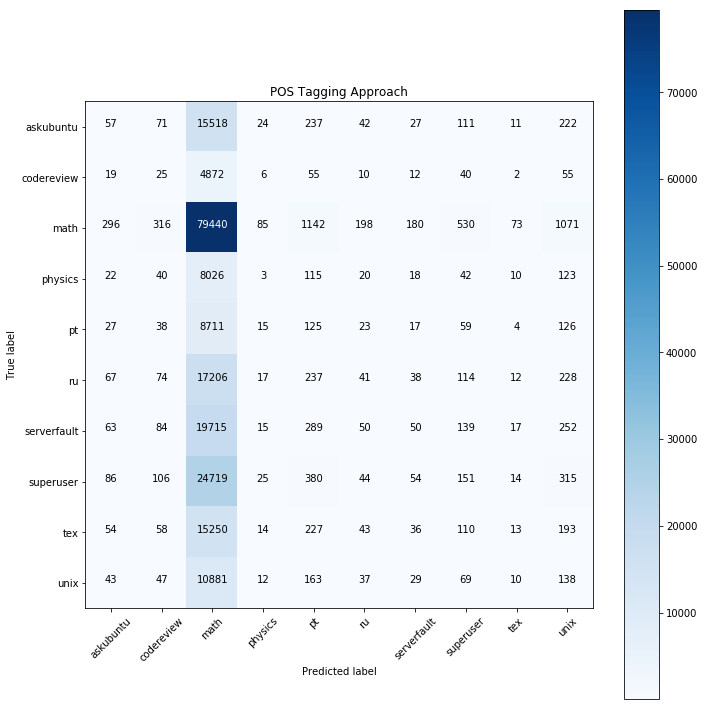

In [171]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pos_cm,normalize=False,classes=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix'],title="POS Tagging Approach")
plt.savefig('POS_Tagging_cm.jpg')

### Why is everything predicted in Math?

In [162]:
pos_mnb = MultinomialNB().fit(pos_train,pos_train_labels)

In [166]:
len(pos_all_words)

34099687

In [170]:
np.unique(full_labels,return_counts=True)

(array(['askubuntu', 'codereview', 'math', 'physics', 'pt', 'ru',
        'serverfault', 'superuser', 'tex', 'unix'], dtype='<U11'),
 array([ 20526,   6422, 103974,  10569,  11438,  22554,  25851,  32244,
         20034,  14313], dtype=int64))

There appears to be some issue with Apriori probability in the POS version of MNB. This could point to the POS tags leading to insufficient information gain and therefore the MNB algorithm is heavily utilizing apriori probablilities to make classifications.<br>
This can be seen by the distribution of questions (the math channel is 3 times more likely to be correct than the second highest channel, superuser). I would also suspect that by leaving in the puctuation during tokenization that we lost some information by leaving <br>
it unique, for example a code snippet typed slightly different would be a separate feature as opposed to the same bare keywords extracted from the snippet.